In [29]:
! nvidia-smi

Sun Apr 23 17:31:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:17:00.0 Off |                  Off |
| 41%   37C    P8    14W / 140W |   8983MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A4000    Off  | 00000000:73:00.0 Off |                  Off |
| 41%   

In [30]:
!pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [31]:
############ Imports ############
import os
import zipfile
import numpy as np
import torch
import os
import cv2
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from pylab import *
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt
from os import path
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
import glob
import re

In [32]:
import numpy as np # linear algebra
import pandas as pd # reading and processing of tables
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
import torch

In [33]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [34]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [35]:
!pip install pytictoc
from pytictoc import TicToc
t = TicToc()

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [36]:
mainVol = np.load('/home/norouzi1/Thesis_FinalResults/Lung/normalizeddata.npy')

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()

        
    def __getitem__(self, index):
        x = self.data[index]
        #x = process_scan(x)
        
        return x
    
    def __len__(self):
        return len(self.data)

trainData = MyDataset(mainVol)
train_loader = DataLoader(trainData,batch_size=10)  

In [38]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=131072):
        return input.view(input.size(0), 64, 16, 16, 8)

In [39]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True,
                 bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

        self.bn = nn.BatchNorm3d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        # print('conv block output',x.shape)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Autoencoders(nn.Module):
    def __init__(self):
        super(Autoencoders, self).__init__()

        self.relu = nn.ReLU(True)

        ##encoder layers
        self.conv_block_1 = BasicConv(1, 16, 3, stride=1, padding=1, bn=True, relu=True)
        self.conv_block_2 = BasicConv(16, 32, 3, stride=1, padding=1, bn=True, relu=True)
        self.conv_block_3 = BasicConv(32, 64, 3, stride=1, padding=1, bn=True, relu=True)
        self.max_pool = nn.MaxPool3d(2)
        self.flatten = Flatten()
        self.enclinear = nn.Linear(131072, 1024)
        ##decoder layers
        self.dec_convtrans_1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec_convtrans_2 = nn.ConvTranspose3d(32, 16, 2, stride=2)
        self.dec_convtrans_3 = nn.ConvTranspose3d(16, 1, 2, stride=2)
        self.deconv_batch_norm_1 = nn.BatchNorm3d(32)
        self.deconv_batch_norm_2 = nn.BatchNorm3d(16)
        self.unflatten = UnFlatten()
        self.declinear = nn.Linear(1024, 131072)

    def forward(self, x):
        # Encoder
        code1 = self.conv_block_1(x)
        # print("code1:", code1.shape)
        code1 = self.max_pool(code1)
        # print("code1:", code1.shape)
        code2 = self.conv_block_2(code1)
        # print("code2:", code2.shape)
        code2 = self.max_pool(code2)
        # print("code2:", code2.shape)
        code3 = self.conv_block_3(code2)
        # print("code3:", code3.shape)
        code3 = self.max_pool(code3)
        #print("code3:", code3.shape)
        code3 = self.flatten(code3)
        # print("code3:", code3.shape)
        code3 = self.enclinear(code3)
        # print("code3:", code3.shape)

        # Decoder
        out1 = self.declinear(code3)
        out1 = self.unflatten(out1)
        out1 = self.dec_convtrans_1(out1)
        # print("out1:", out1.shape)
        out1 = self.deconv_batch_norm_1(out1)
        # print("out1:", out1.shape)
        out2 = self.dec_convtrans_2(out1)
        # print("out2:", out2.shape)
        out2 = self.deconv_batch_norm_2(out2)
        # print("out2:", out2.shape)
        out3 = self.dec_convtrans_3(out2)
        # print("out3:", out3.shape)

        return code3, out3

In [ ]:
model = Autoencoders()
model = model.to(device)
print(model)

In [ ]:
# specify loss function
criterion = nn.MSELoss()
# specify loss function
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 500

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        data = data.unsqueeze(1)
        data = data.to(device, dtype=torch.float)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        encout, outputs = model(data)
        # calculate the loss
        loss = criterion(outputs, data)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)

    # print avg training statistics
    train_loss = train_loss / len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
    ))

In [ ]:
torch.save(model, '/home/norouzi1/Lung/SecondVer/SavedModels/Autoencoder.pth')

In [ ]:
enc_output = np.empty((0, 1024), int)
for data in train_loader:
    data = data.unsqueeze(1)
    data = data.to(device=device, dtype=torch.float)
    encout, outputs = model(data)
    encout = encout.detach().cpu().clone().numpy()
    enc_output = np.append(enc_output, encout, axis=0)
    print(enc_output.shape)

In [ ]:
enctxt = np.savetxt("/home/norouzi1/Lung/SecondVer/SavedModels/enc7.txt", enc_output)

In [40]:
enc_output = np.loadtxt("/home/norouzi1/Lung/SecondVer/SavedModels/enc7.txt")
enc_output = enc_output.astype(int)

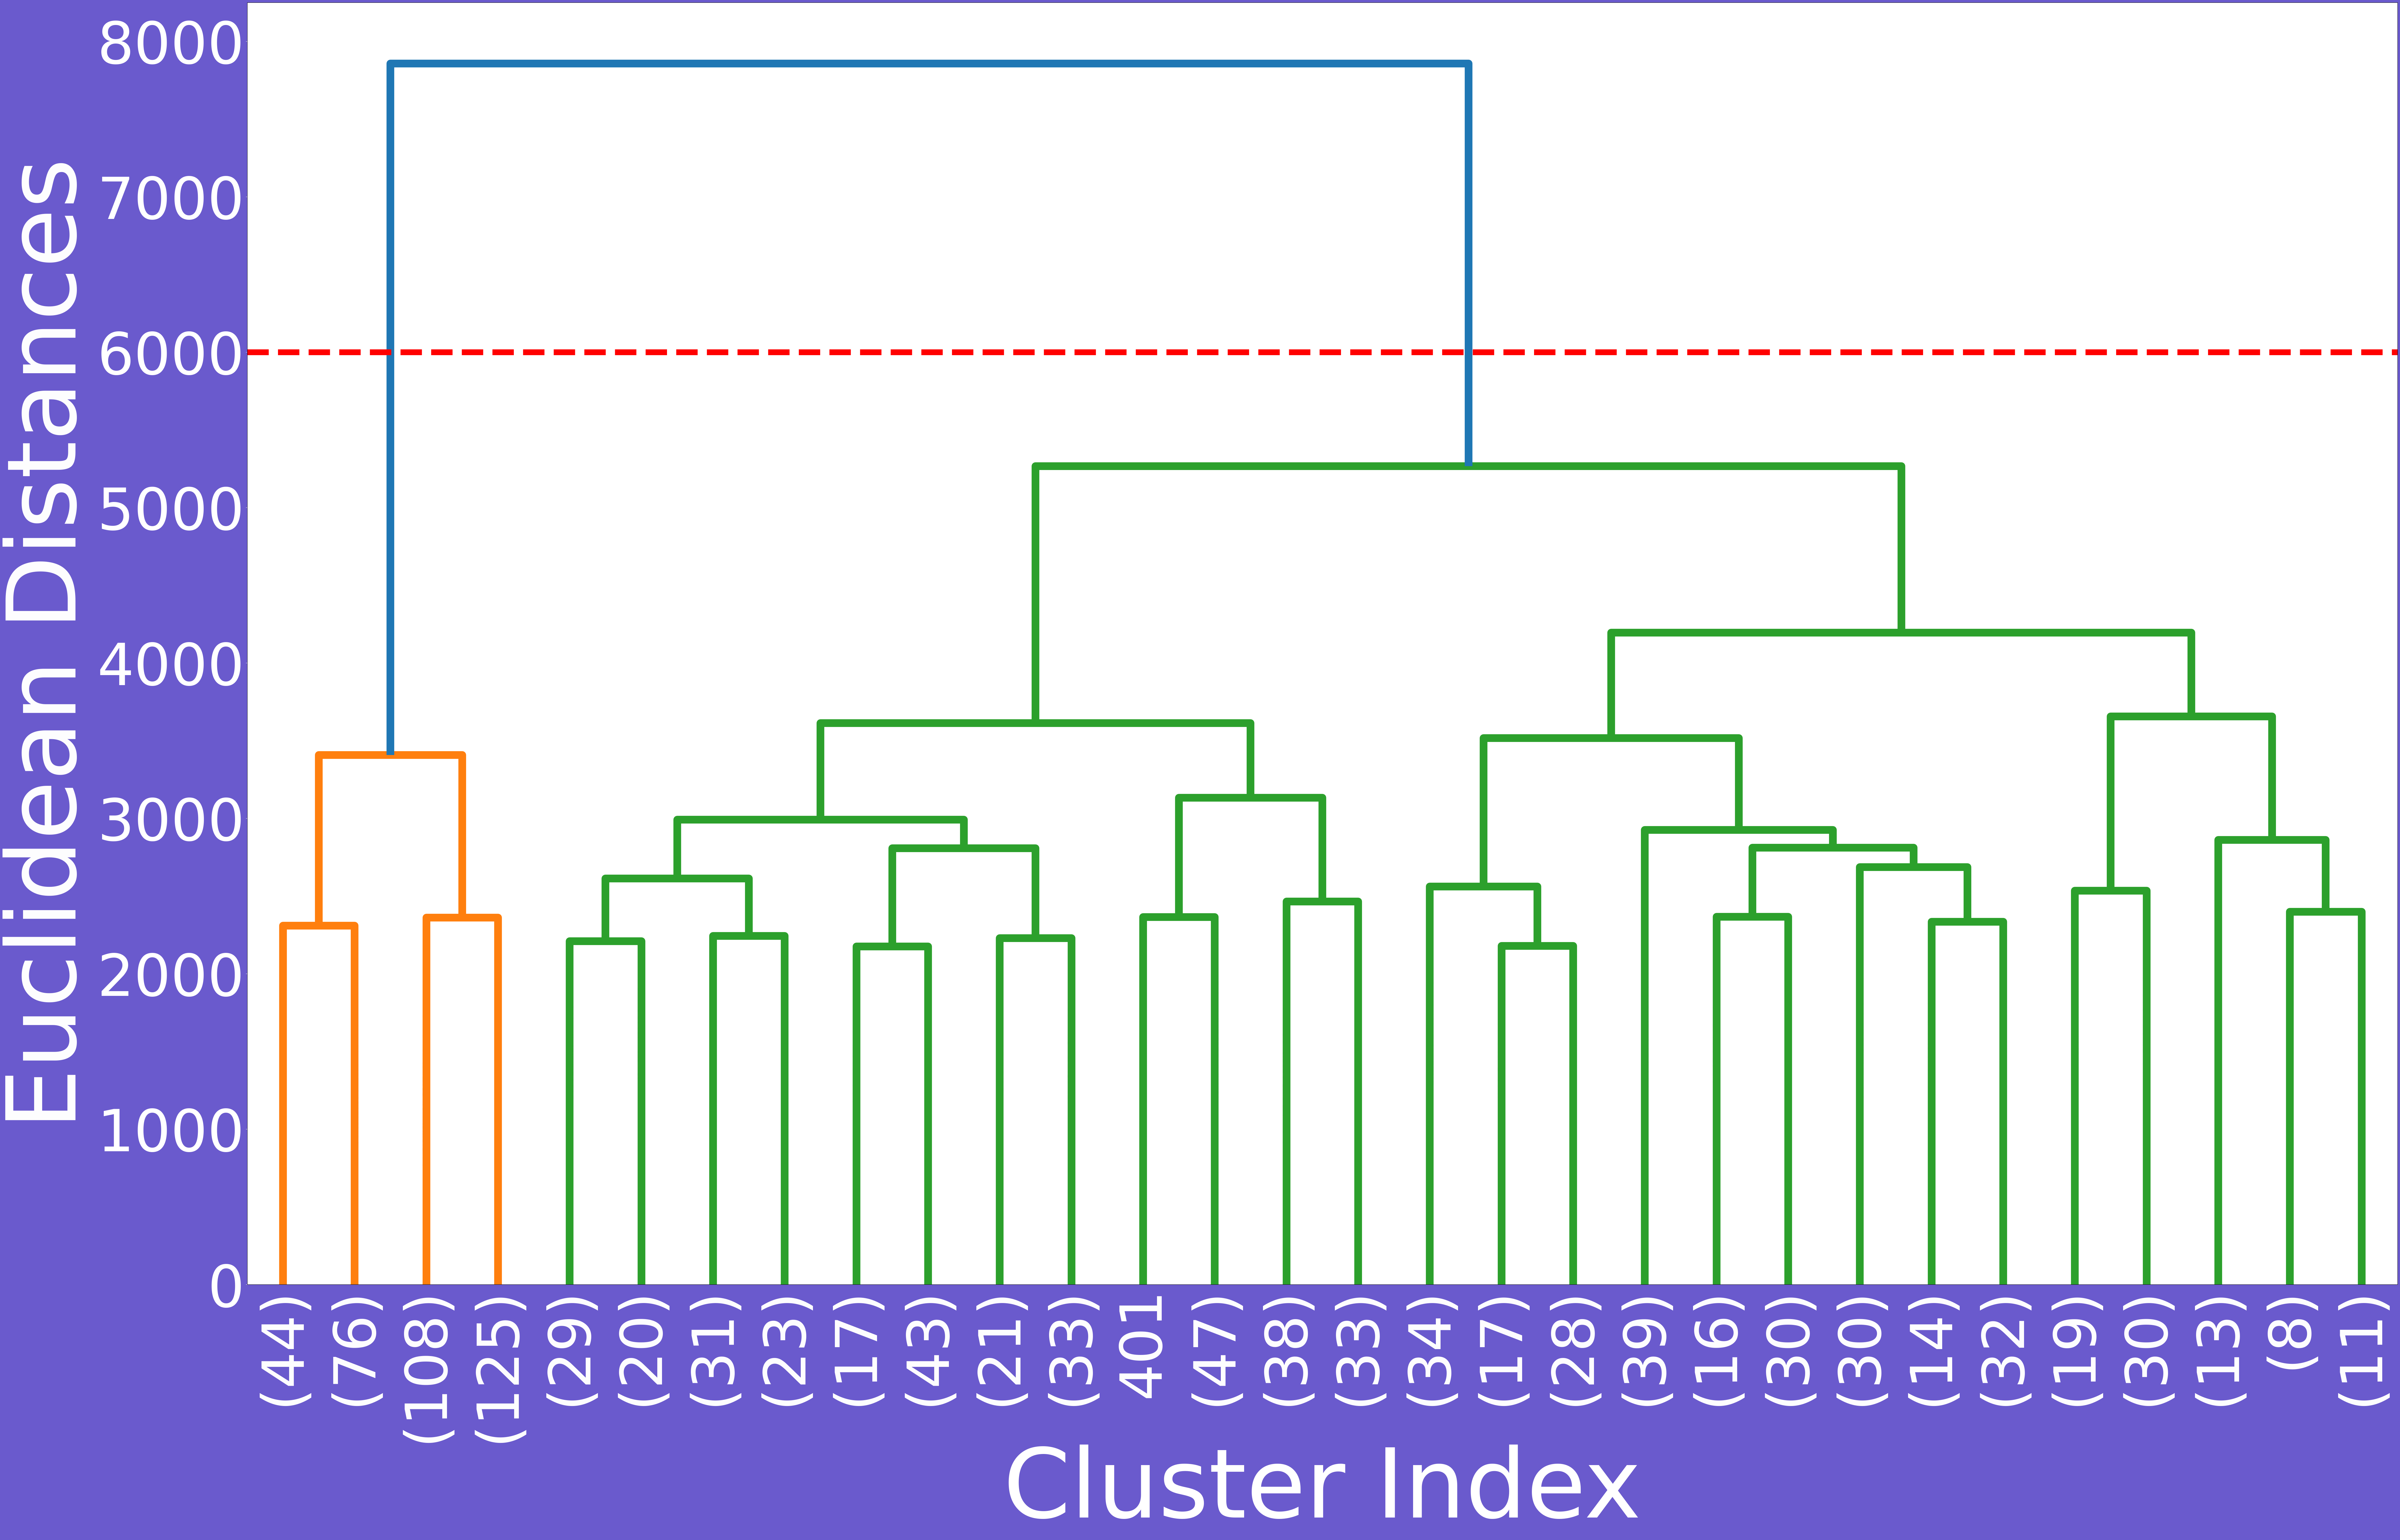

In [57]:
import scipy.cluster.hierarchy as shc
from os import path
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 20
fig = plt.figure(figsize=(100, 60))
fig.patch.set_facecolor('slateblue')
plt.xlabel("Cluster Index", fontsize=250, color='white')
plt.ylabel("Euclidean Distances", fontsize=250, color='white')
dend = shc.dendrogram(shc.linkage(enc_output, method='ward'),
                      truncate_mode='lastp',  # show only the last p merged clusters
                      p=30,  # show only the last p merged clusters
                      leaf_rotation=90.,
                      leaf_font_size=12.,
                      show_contracted=True,
                      # color_threshold=5500,
                      )
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=150, colors='white')
ax.tick_params(axis='y', which='major', labelsize=150, colors='white')

# Add a horizontal line for 2 clusters
ax.axhline(y=6000, linestyle='--', color='red', linewidth=15)

# Get the x-positions of the vertical lines
x_vals = dend['icoord']

# Iterate over the x-positions and find the intersection points with the horizontal line
for i, x in enumerate(x_vals):
    for j in range(len(x)):
        y = dend['dcoord'][i][j]
        if abs(y - 6000) < 1e-5:  # check if the y-coordinate is close to the horizontal line
            ax.annotate('', xy=(x[j], y), xytext=(x[j], y + 20), arrowprops=dict(facecolor='white', edgecolor='white', arrowstyle='-|>,head_width=1,head_length=3'), fontsize=150)

plt.savefig('/home/norouzi1/Thesis_FinalResults/Lung/SavedModels/HC.png')
plt.show()


In [ ]:
import re
from sklearn.metrics import pairwise_distances

avg_dist = []

for c in range(1,11):
  cluster = AgglomerativeClustering(n_clusters=c, affinity='euclidean', linkage='ward')
  members = cluster.fit_predict(enc_output)
  k = np.unique(members)
  num_clusters = k.shape[0]
  sum = 0
  for cluster in range(num_clusters):
    cluster_sum = 0  
    cluster_sum = pairwise_distances(enc_output[members == cluster]).mean()  
    sum += cluster_sum
  sum = sum/num_clusters
  avg_dist.append(sum)

print(avg_dist)

In [ ]:
distance_txt = np.savetxt("/home/norouzi1/Lung/SecondVer/SavedModels/avg_dist7.txt", avg_dist)

In [27]:
avg_dist = np.loadtxt('/home/norouzi1/Thesis_FinalResults/Lung/SavedModels/avg_dist10.txt')
avg_dist = avg_dist.astype(int)

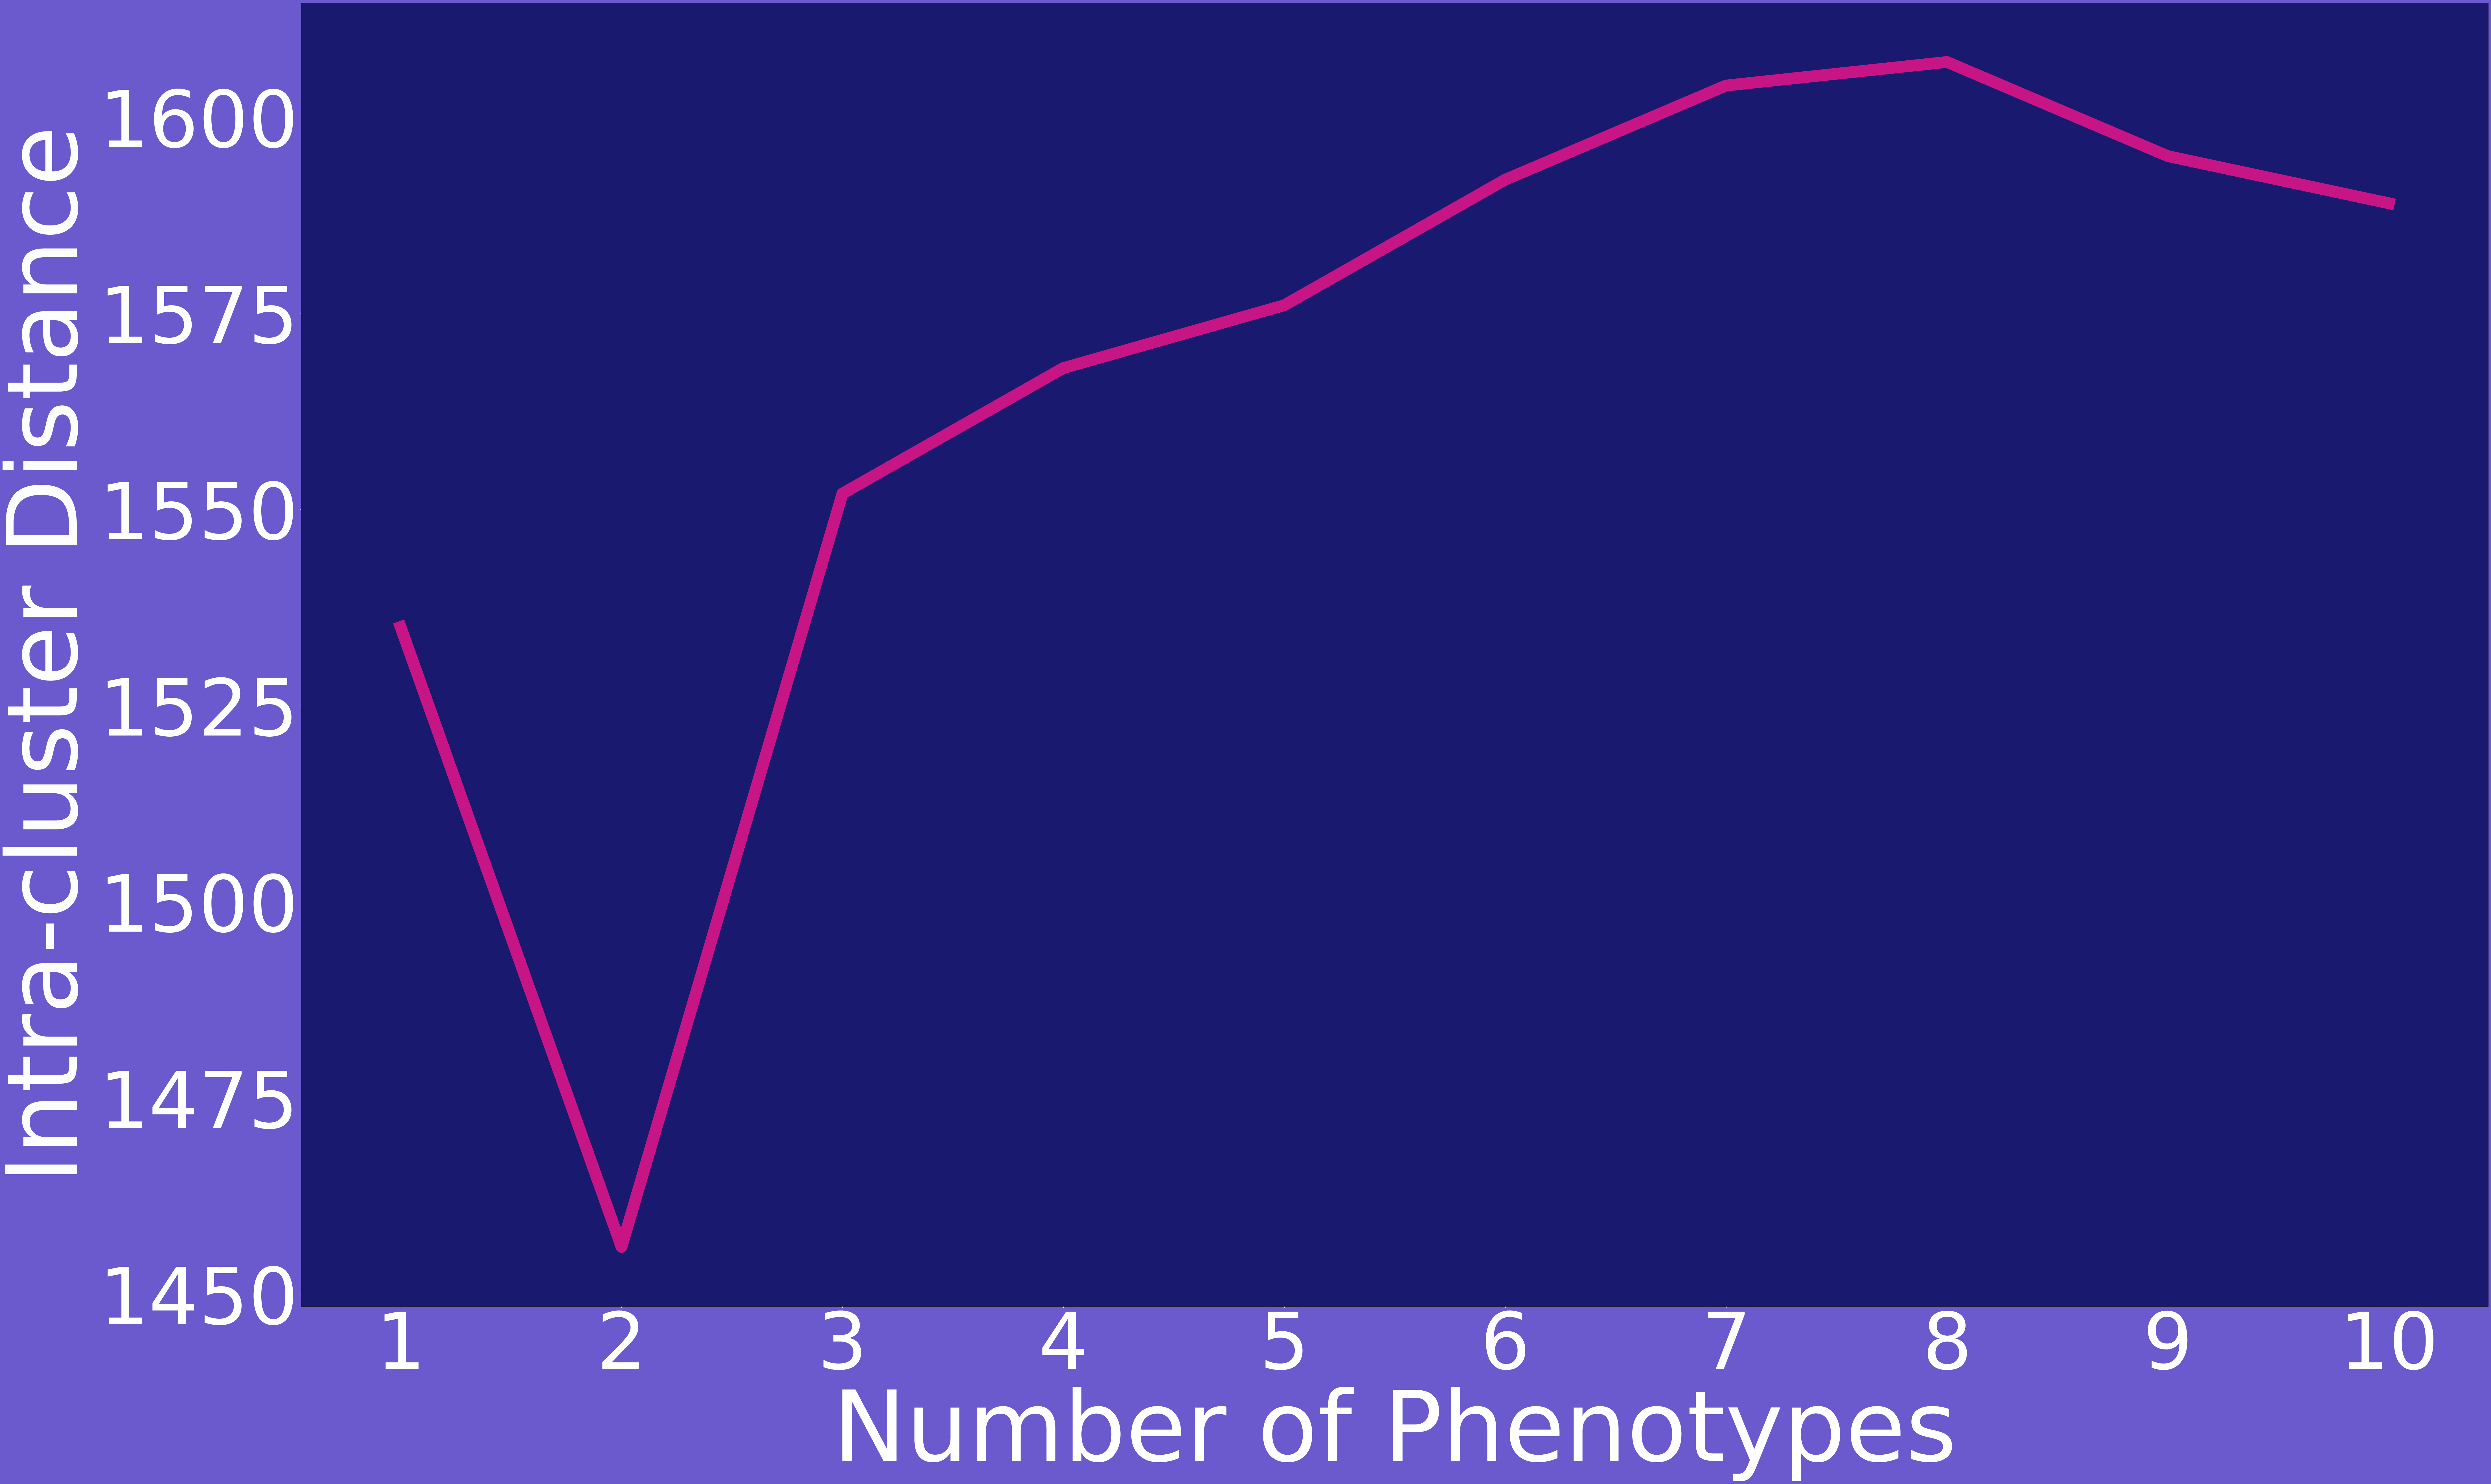

In [28]:
plt.rcParams['lines.linewidth'] = 30
fig = plt.figure(figsize=(100, 60))
fig.patch.set_facecolor('slateblue')
plt.xlabel("Number of Phenotypes", fontsize=250, color='white')
plt.ylabel("Intra-cluster Distance", fontsize=250, color='white')
plt.plot(range(1,11), avg_dist, color='mediumvioletred')
plt.xticks(range(1, 11))
ax = plt.gca()
ax.set_facecolor('midnightblue')
ax.tick_params(axis='x', labelsize=200, colors='white')
ax.tick_params(axis='y', labelsize=200, colors='white')
#vlines(x=14, ymin=bottom, ymax=avg_dist[15], linewidth=4, color='r')
plt.savefig('/home/norouzi1/Thesis_FinalResults/Lung/SavedModels/elbow10.png')
plt.show()

In [ ]:
test1 = []
for i in range(0,10):    
    test = (avg_dist[i-1] - avg_dist[i]) / avg_dist[i-1]
    test1.append(test)

print(test1)
max_value = max(test1)
index = test1.index(max_value)
print(index+1)

In [ ]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
members = cluster.fit_predict(enc_output)

In [ ]:
labels = members
labels

In [ ]:
labelstxt = np.savetxt("/home/norouzi1/Lung/SecondVer/SavedModels/labels.txt", labels)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = labels.long()
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)

labels = torch.from_numpy(members)
trainData = MyDataset(mainVol, labels)
train_loader = DataLoader(trainData,batch_size=10)  

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassificationModel(nn.Module):   
    def __init__(self):
        super(ClassificationModel, self).__init__()

        self.features = nn.Sequential(
            # Defining a 3D convolution layer
            nn.Conv3d(1,64,3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),
            # Defining another 3D convolution layer
            nn.Conv3d(64,32,3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),
            # Defining another 3D convolution layer
            nn.Conv3d(32,16,3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2))
        )

        self.classifier = nn.Sequential(
            Flatten(),
            nn.Linear(32768, 256),
            nn.ReLU(inplace=True),
            #nn.Dropout3d(p=0.5),
            nn.Linear(256, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
model = ClassificationModel()
model = model.to(device)
print(model)

In [ ]:
t.tic()
#specify loss function
criterion = nn.CrossEntropyLoss()
# specify loss function
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 50
for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, labels in train_loader:
        data = data.unsqueeze(1)
        data = data.to(device, dtype=torch.float)
        labels = labels.to(device=device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(data)
        # calculate the loss
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)

    # print avg training statistics
    train_loss = train_loss / len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
    ))

timeTaken = t.tocvalue()/60
dispMsg = "++++ Total Time Taken: %.2f" % timeTaken
print( dispMsg)

In [ ]:
torch.save(model, '/home/norouzi1/Lung/SecondVer/SavedModels/Classifier.pth')

In [ ]:
class GradCAMModel(nn.Module):
    def __init__(self):
        super(GradCAMModel, self).__init__()
        
        # get the classification network
        self.gradcam = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.gradcam.features[:11]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool3d((2,2,2))
        
        # get the classifier of the model
        self.classifier = self.gradcam.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [ ]:
model2 = GradCAMModel()
model2 = model2.to(device)

In [ ]:
torch.save(model2, '/home/norouzi1/Lung/SecondVer/SavedModels/GradCAM.pth')